# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense , Dropout
from sklearn.metrics import mean_squared_error,r2_score
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

# Setting Base Path for File Operations.

In [2]:
def set_base_path(base_path):
    """
    Set the base path for file operations.

    Parameters:
    - base_path (str): The base path to set.

    Returns:
    - None
    """
    global BASE_PATH
    BASE_PATH = base_path

def construct_file_path(relative_path):
    """
    Construct the full file path using the base path and the relative path.

    Parameters:
    - relative_path (str): The relative path from the base path.

    Returns:
    - full_path (str): The full file path.
    """
    if 'BASE_PATH' not in globals():
        raise ValueError("Base path is not set. Call set_base_path() first.")

    full_path = os.path.join(BASE_PATH, relative_path)
    return full_path

# usage
set_base_path(r"F:\DataScience\code\stock-prediction")

# Load Data

In [3]:
# Construct the full file path for data/AAPL_use(1).csv
file_path_1 = construct_file_path("data/AAPL_use(1).csv")

# Now you can use file_path to read the CSV file
df1 = pd.read_csv(file_path_1)

print(df1['Close'].shape)

(4027,)


In [4]:
# Construct the full file path for data/AAPL_use(2).csv
file_path_2 = construct_file_path("data/AAPL_use(2).csv")

# Now you can use file_path to read the CSV file
df2 = pd.read_csv(file_path_2)

print(df2['Close'].shape)

(1762,)


In [5]:
# Removing %h-%m-%s From Date Column in df1
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Date'] = df1['Date'].dt.strftime('%d-%m-%Y')
print(df1)

            Date        Open        High         Low       Close   Adj Close  \
0     30-10-2007    6.649286    6.763214    6.597500    6.678571    5.668749   
1     31-10-2007    6.701071    6.790000    6.605357    6.783929    5.758174   
2     01-11-2007    6.735714    6.789286    6.428571    6.694286    5.682087   
3     02-11-2007    6.757500    6.765714    6.553214    6.709643    5.695121   
4     05-11-2007    6.617500    6.748571    6.580000    6.649286    5.643891   
...          ...         ...         ...         ...         ...         ...   
4022  23-10-2023  170.910004  174.009995  169.929993  173.000000  173.000000   
4023  24-10-2023  173.050003  173.669998  171.449997  173.440002  173.440002   
4024  25-10-2023  171.880005  173.059998  170.649994  171.100006  171.100006   
4025  26-10-2023  170.369995  171.380005  165.669998  166.889999  166.889999   
4026  27-10-2023  166.910004  168.960007  166.830002  168.220001  168.220001   

          Volume  
0      939414000  
1

In [6]:
# Assuming df1 and df2 are your DataFrames
# Concatenate df1 and df2 along the rows (axis=0)
df = pd.concat([df1, df2], axis=0)

# Reset index if needed
df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
print(df)

            Date        Open        High         Low       Close  Adj Close  \
0     30-10-2007    6.649286    6.763214    6.597500    6.678571   5.668749   
1     31-10-2007    6.701071    6.790000    6.605357    6.783929   5.758174   
2     01-11-2007    6.735714    6.789286    6.428571    6.694286   5.682087   
3     02-11-2007    6.757500    6.765714    6.553214    6.709643   5.695121   
4     05-11-2007    6.617500    6.748571    6.580000    6.649286   5.643891   
...          ...         ...         ...         ...         ...        ...   
5784  23-12-2016  115.589996  116.519997  115.589996  116.519997        NaN   
5785  27-12-2016  116.519997  117.800003  116.489998  117.260002        NaN   
5786  28-12-2016  117.519997  118.019997  116.199997  116.760002        NaN   
5787  29-12-2016  116.449997  117.110001  116.400002  116.730003        NaN   
5788  30-12-2016  116.650002  117.199997  115.430000  115.820000        NaN   

          Volume  ADJ Close Stock  
0      93941400

In [7]:
# Remove the "Adj Close" and "ADJ Close Stock" columns
df = df.drop(["Adj Close", "ADJ Close Stock"], axis=1)

# Display the modified DataFrame
print(df)

            Date        Open        High         Low       Close      Volume
0     30-10-2007    6.649286    6.763214    6.597500    6.678571   939414000
1     31-10-2007    6.701071    6.790000    6.605357    6.783929   833310800
2     01-11-2007    6.735714    6.789286    6.428571    6.694286   805036400
3     02-11-2007    6.757500    6.765714    6.553214    6.709643  1002114400
4     05-11-2007    6.617500    6.748571    6.580000    6.649286   804176800
...          ...         ...         ...         ...         ...         ...
5784  23-12-2016  115.589996  116.519997  115.589996  116.519997    14249500
5785  27-12-2016  116.519997  117.800003  116.489998  117.260002    18296900
5786  28-12-2016  117.519997  118.019997  116.199997  116.760002    20905900
5787  29-12-2016  116.449997  117.110001  116.400002  116.730003    15039500
5788  30-12-2016  116.650002  117.199997  115.430000  115.820000    30586300

[5789 rows x 6 columns]


# Data Preprocessing

In [11]:
# Check for missing values
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print("Missing Values:", missing_values)

# Check if any missing values are found
if missing_values.any():
    print("\nThere are missing values in the dataset.")
else:
    print("\nNo missing values found in the dataset.")

# Removing %h-%m-%s From Date Column
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')
df

Missing Values: Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

No missing values found in the dataset.


,Date,Open,High,Low,Close,Volume
0,30-10-2007,6.649286,6.763214,6.597500,6.678571,939414000
1,31-10-2007,6.701071,6.790000,6.605357,6.783929,833310800
2,01-11-2007,6.735714,6.789286,6.428571,6.694286,805036400
3,02-11-2007,6.757500,6.765714,6.553214,6.709643,1002114400
4,05-11-2007,6.617500,6.748571,6.580000,6.649286,804176800
...,...,...,...,...,...,...
5784,23-12-2016,115.589996,116.519997,115.589996,116.519997,14249500
5785,27-12-2016,116.519997,117.800003,116.489998,117.260002,18296900
5786,28-12-2016,117.519997,118.019997,116.199997,116.760002,20905900
5787,29-12-2016,116.449997,117.110001,116.400002,116.730003,15039500


In [13]:
# Checking The Type Of Data Column(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5789 entries, 0 to 5788
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5789 non-null   object 
 1   Open    5789 non-null   float64
 2   High    5789 non-null   float64
 3   Low     5789 non-null   float64
 4   Close   5789 non-null   float64
 5   Volume  5789 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 271.5+ KB


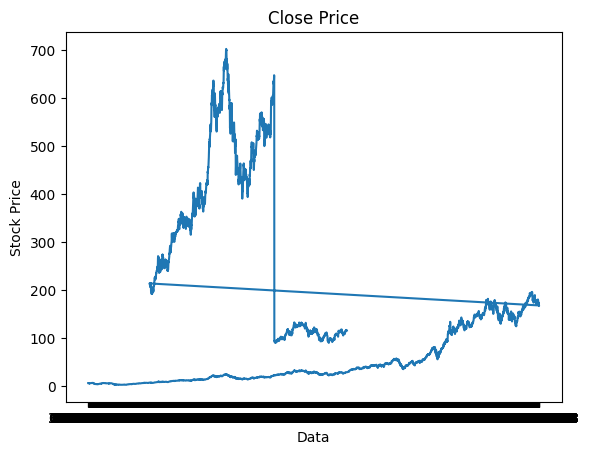

In [14]:
plt.plot(df['Date'],df['Close'])
plt.title('Close Price')
plt.xlabel('Data')
plt.ylabel('Stock Price')
plt.show()

In [15]:
df.shape

(5789, 6)

# Normalization

In [16]:
# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[0.00555652],
       [0.00570718],
       [0.00557899],
       ...,
       [0.16297151],
       [0.16292861],
       [0.16162732]])

# Data Preparation

In [19]:
# Define input sequence length and target sequence length
sequence_length = 50 # Number of previous days to consider for prediction
target_length = 1  # Predicting only one day ahead 

In [20]:
# Create sequences
def create_sequences(data, sequence_length, target_length):
    """
    Prepare the data for sequence modeling by converting an array of values into a dataset matrix.

    Parameters:
    - data: The input data as a numpy array.
    - time_steps: The number of time steps to consider for each sample.

    Returns:
    - X: The input features matrix.
    - y: The target variable vector.
    
    """
    X, y = [], [] 
    for i in range(len(data) - sequence_length - target_length):
        X.append(data[i:(i + sequence_length)]) # add without removing the previous data
        y.append(data[(i + sequence_length):(i + sequence_length + target_length)])
        if i <= 1:
            """Print the first few samples of X and y for debugging purposes."""
            print("X:", X)
            print("y:", y)
            print()
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, sequence_length, target_length)

X: [array([[0.00555652],
       [0.00570718],
       [0.00557899],
       [0.00560095],
       [0.00551464],
       [0.00580115],
       [0.00552077],
       [0.00496767],
       [0.00445185],
       [0.00385892],
       [0.00468627],
       [0.00448965],
       [0.00439721],
       [0.00450395],
       [0.00437933],
       [0.00462958],
       [0.00460967],
       [0.00476696],
       [0.00481803],
       [0.00493396],
       [0.00521026],
       [0.00541812],
       [0.0053124 ],
       [0.0051408 ],
       [0.00518932],
       [0.00547991],
       [0.00570718],
       [0.00592934],
       [0.00592474],
       [0.00563517],
       [0.00575365],
       [0.00580319],
       [0.00572965],
       [0.00542374],
       [0.00535122],
       [0.00535836],
       [0.00556724],
       [0.00590942],
       [0.00615916],
       [0.00616682],
       [0.00614741],
       [0.00621176],
       [0.00612239],
       [0.00595692],
       [0.00596151],
       [0.00520158],
       [0.0050785 ],
       [0

In [21]:
# Reshape data for CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("the number of training data: " + str(len(X_train)))
print("the number of training data: " + str(len(X_test)))

the number of training data: 4590
the number of training data: 1148


# Training CNN Model

In [22]:
# Build CNN model
model = Sequential()
model.add(Conv1D(filters=32  
                 , kernel_size=3
                 , activation='relu',
                 strides=1,
                 input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2, strides=1) )
model.add(Conv1D(filters=64  
                 , kernel_size=3
                 , activation='relu',
                 strides=2,
                 ))
model.add(MaxPooling1D(pool_size=2, strides=2)) 
model.add(Flatten()) 
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu')) # 128 neurons
model.add(Dense(target_length, activation='sigmoid')) # one output layer

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compile the model with specified learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['accuracy'])

# Train model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 2.3440e-04 - loss: 0.0584 - val_accuracy: 0.0000e+00 - val_loss: 0.0033
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 3.8727e-04 - loss: 0.0020 - val_accuracy: 0.0000e+00 - val_loss: 0.0020
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 5.2695e-04 - loss: 0.0022 - val_accuracy: 0.0000e+00 - val_loss: 0.0023
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 7.1217e-04 - loss: 0.0013 - val_accuracy: 0.0000e+00 - val_loss: 0.0013
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 4.5322e-05 - loss: 0.0015 - val_accuracy: 0.0000e+00 - val_loss: 0.0015
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 4.0435e-05 - loss: 8.6736e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.5602e-04 - loss: 9.5296e-04 - val_accuracy: 0.0000e+00 - val_loss: 9.3212e-04
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━

# Evaluation Model

In [24]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


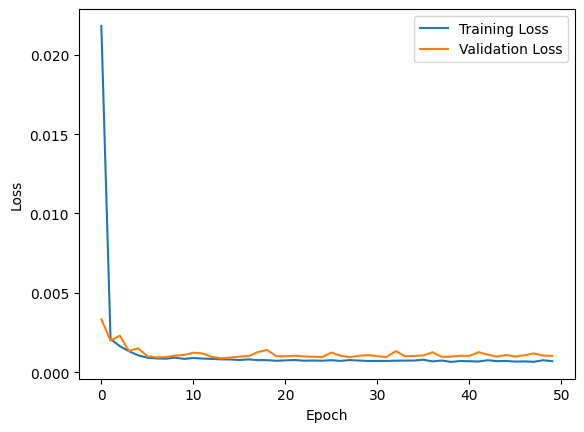

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 48, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 47, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 23, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          90,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 290,117 (1.11 MB)

 Trainable params: 96,705 (377.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 193,412 (755.52 KB)

In [27]:
# Calculate R2 score and MSE for training data
train_r2 = r2_score(y_train.reshape(-1), train_predictions.reshape(-1))
train_mse = mean_squared_error(y_train.reshape(-1), train_predictions.reshape(-1))

# Calculate R2 score and MSE for testing data
test_r2 = r2_score(y_test.reshape(-1), test_predictions.reshape(-1))
test_mse = mean_squared_error(y_test.reshape(-1), test_predictions.reshape(-1))

# Print evaluation metrics
print(f'Training R2 Score: {train_r2}')
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing R2 Score: {test_r2}')
print(f'Testing Mean Squared Error: {test_mse}')


Training R2 Score: 0.9882357850728962
Training Mean Squared Error: 0.0006501182197555621
Testing R2 Score: 0.9813481952593047
Testing Mean Squared Error: 0.0010295144707587426


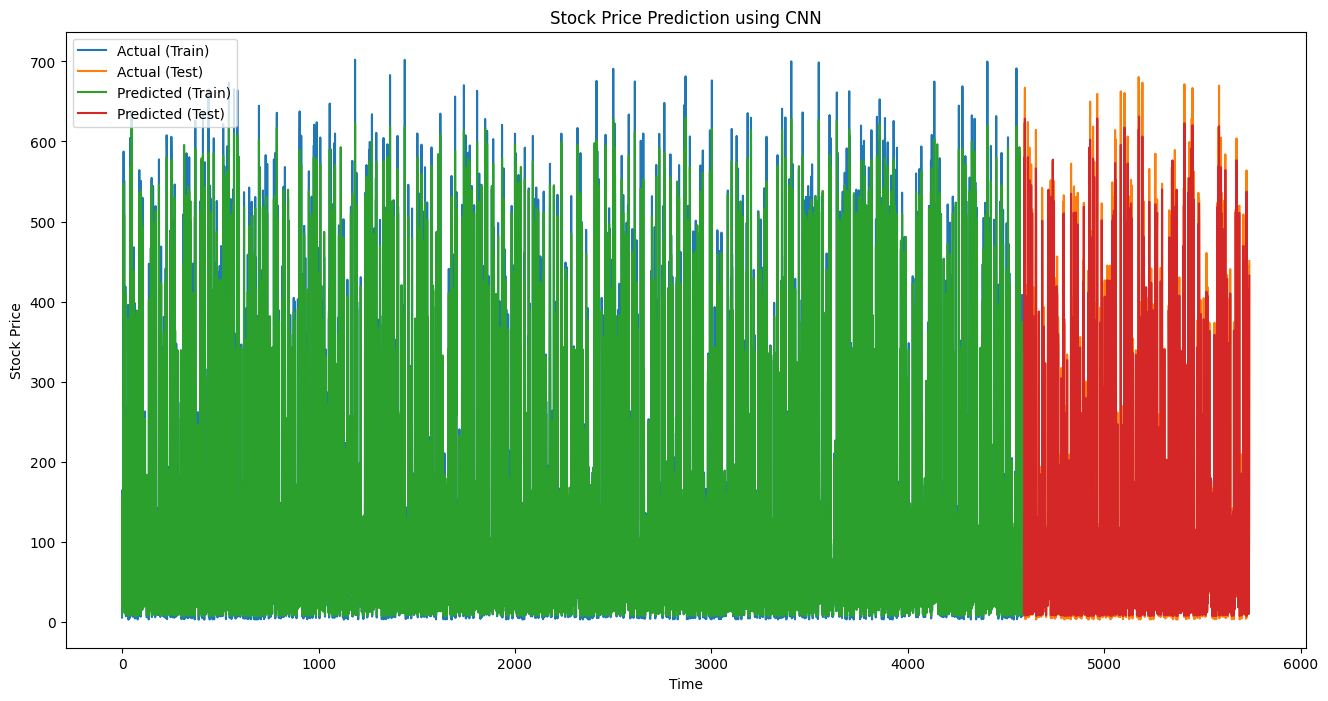

In [28]:
# Plot predictions
plt.figure(figsize=(16, 8))
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Actual (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual (Test)')
plt.plot(np.arange(len(y_train)), scaler.inverse_transform(train_predictions), label='Predicted (Train)')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), scaler.inverse_transform(test_predictions), label='Predicted (Test)')
plt.title('Stock Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()